In [ ]:
#任务为加载预训练vgg16模型对猫狗数据库进行特征提取，然后把全连接层替换为自己的mlp


In [3]:
#下载数据库
import kagglehub
import os
# Download latest version
path = kagglehub.dataset_download("bhavikjikadara/dog-and-cat-classification-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/dog-and-cat-classification-dataset


In [4]:
#检查文件是否存在
files = os.listdir('/kaggle/input/dog-and-cat-classification-dataset')
print(files)
dataset_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages'
file = os.listdir(dataset_path)
print(file)

['PetImages']
['Dog', 'Cat']


In [11]:
#加载单张数据
from keras.preprocessing.image import load_img,img_to_array
pic_dog_path = '/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog/0.jpg'
pic_dog = load_img(pic_dog_path,target_size=(224,224))#VGG所要的大小
pic_dog = img_to_array(pic_dog)
print(pic_dog.shape)

(224, 224, 3)


In [12]:
#使用vgg16进行特征提取
from keras.applications.vgg16 import VGG16,preprocess_input
model = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
x = preprocess_input(pic_dog.reshape((1,224,224,3)))
print(x.shape)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(1, 224, 224, 3)


In [14]:
#特征提取
features = model.predict(x)
print(features.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 981ms/step
(1, 7, 7, 512)


In [15]:
#展平方便进入全连接层
features = features.reshape(1,7*7*512)
print(features.shape)


(1, 25088)


(224, 224)


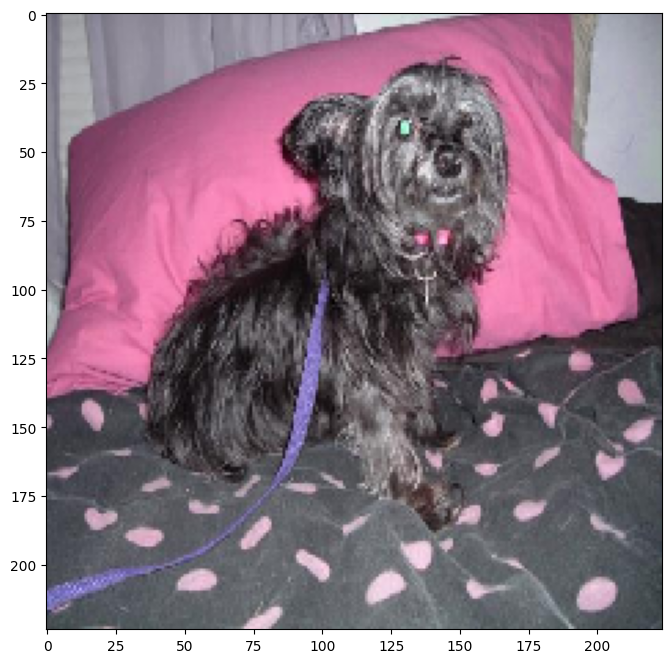

In [23]:
#可视化图片
%matplotlib inline
import matplotlib.pyplot as plt
fig0 = plt.figure(figsize=(8,8))
img = load_img(pic_dog_path,target_size=(224,224))
plt.imshow(img)
print(img.size)

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
import numpy as np
import os
from tqdm import tqdm  # 用于显示进度条

print("加载VGG16模型...")
# 加载VGG16模型作为特征提取器
model_vgg = VGG16(weights="imagenet", include_top=False)
print("VGG16模型加载完成!")

def modelProcess(img_path, model):
    """处理单张图像并提取VGG16特征"""
    try:
        # 加载并调整图像大小为VGG16所需的224x224
        img = load_img(img_path, target_size=(224, 224))
        # 转换为数组
        img = img_to_array(img)
        # 添加批次维度
        x = np.expand_dims(img, axis=0)
        # 应用VGG16专用预处理
        x = preprocess_input(x)
        # 使用VGG16提取特征
        x_vgg = model.predict(x, verbose=0)  # 禁用进度条
        # 展平为一维向量 (1, 7*7*512)
        x_vgg = x_vgg.reshape(1, 7*7*512)
        return x_vgg
    except Exception as e:
        print(f"处理图像 {img_path} 时出错: {e}")
        return None

def extract_features(folder_path, extension=".jpg"):
    """从指定文件夹中提取所有图像的特征"""
    # 检查文件夹是否存在
    if not os.path.exists(folder_path):
        print(f"错误: 文件夹 {folder_path} 不存在!")
        return None, 0

    # 获取所有指定扩展名的图像文件
    image_files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(extension.lower()):
            image_files.append(os.path.join(folder_path, filename))

    if not image_files:
        print(f"警告: 在 {folder_path} 中没有找到 {extension} 文件!")
        return None, 0

    print(f"在 {folder_path} 中找到 {len(image_files)} 张图像.")

    # 创建存储特征的数组
    features = np.zeros([len(image_files), 25088])
    valid_count = 0

    # 处理每张图像并提取特征
    print(f"开始处理图像...")
    for i, img_path in enumerate(tqdm(image_files)):
        feature = modelProcess(img_path, model_vgg)
        if feature is not None:
            features[valid_count] = feature
            valid_count += 1

    # 如果有处理失败的图像，调整特征数组大小
    if valid_count < len(image_files):
        print(f"注意: {len(image_files) - valid_count} 张图像处理失败.")
        features = features[:valid_count]

    return features, valid_count

# 主程序
def main():
    # 设置数据路径
    cat_folder = "/kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat"
    dog_folder = "/kaggle/input/dog-and-cat-classification-dataset/PetImages/Dog"

    print("\n==== 开始处理猫图像 ====")
    cat_features, cat_count = extract_features(cat_folder)
    if cat_features is None or cat_count == 0:
        print("处理猫图像失败!")
        return

    print("\n==== 开始处理狗图像 ====")
    dog_features, dog_count = extract_features(dog_folder)
    if dog_features is None or dog_count == 0:
        print("处理狗图像失败!")
        return

    print("\n==== 准备数据集 ====")
    # 创建标签
    cat_labels = np.zeros(cat_count)
    dog_labels = np.ones(dog_count)

    # 合并特征和标签
    X = np.concatenate((cat_features, dog_features), axis=0)
    y = np.concatenate((cat_labels, dog_labels), axis=0)
    y = y.reshape(-1, 1)

    # 限制样本数量(如果需要)
    max_samples = min(500, len(X))
    X = X[:max_samples]
    y = y[:max_samples]

    print(f"\n特征提取完成!")
    print(f"猫特征形状: {cat_features.shape}")
    print(f"狗特征形状: {dog_features.shape}")
    print(f"合并后数据集: X形状 {X.shape}, y形状 {y.shape}")

    # 保存特征和标签以备后用
    try:
        np.save("vgg16_features.npy", X)
        np.save("vgg16_labels.npy", y)
        print("特征和标签已保存为 vgg16_features.npy 和 vgg16_labels.npy")
    except Exception as e:
        print(f"保存数据时出错: {e}")

if __name__ == "__main__":
    main()

加载VGG16模型...
VGG16模型加载完成!

==== 开始处理猫图像 ====
在 /kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat 中找到 12499 张图像.
开始处理图像...


  5%|▍         | 592/12499 [07:40<2:13:26,  1.49it/s]

In [ ]:
#分割测试和训练数据
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=50)
print(X_train.shape,X_test.shape,X.shape)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=10,activation="relu",input_dim=25088))
model.add(Dense(units=1,activation="sigmoid"))
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['accuracy'])


In [ ]:
#开始训练
model.fit(X_train,y_train,epochs=50)


In [ ]:
#检查准确率